In [19]:
import pandas as pd

In [20]:
sample = 10000

product = ['code', 'countries_en','url', 'product_name', 'brands', 'categories_en']

nutrient = ['energy_100g','saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g']

columns_to_load = product + nutrient

opf_data = pd.read_csv('/Users/baslad01/data_dump/openfoodfacts/product_data/en.openfoodfacts.org.products.csv', sep='\t', encoding='utf-8',
                       on_bad_lines='skip',
                       usecols=columns_to_load,
                       nrows=sample)

In [22]:
def calculate_npm_score(row):
    try:
        # Category A points (detrimental components)
        a_points = 0
        a_points += row['energy_100g'] // 335  # Energy (kJ) - 1 point per 335kJ
        a_points += min(10, row['saturated-fat_100g'] // 1) # Saturated fat (g) - max 10 points
        a_points += min(10, row['sugars_100g'] // 4.5)  # Total sugars (g) - max 10 points
        a_points += row['sodium_100g'] // 0.09  # Sodium (g) - 1 point per 0.09g

        # Category C points (beneficial components)
        c_points = 0
        # Check if fruit/vegetable/nut content is available. Open Food Facts doesn't have a direct field for this.
        # You would need to add this information if you want to use this part of the model.
        # For this example I will set it to 0
        fruit_veg_nut_content = 0
        c_points += fruit_veg_nut_content

        c_points += row['fiber_100g'] // 0.8  # Fibre (g) - 1 point per 0.8g
        c_points += row['proteins_100g'] // 1.6  # Protein (g) - 1 point per 1.6g

        # Final NPM score
        npm_score = a_points - c_points

        # Protein cap (if A points >= 11 and fruit/veg/nut content < 5)
        if a_points >= 11 and fruit_veg_nut_content < 5:
          npm_score = a_points - (c_points - row['proteins_100g'] // 1.6)

        return npm_score
    except (TypeError, KeyError):  # Handle missing or non-numeric data
        return None

# Convert to numeric, handling errors
for col in nutrient:
    opf_data[col] = pd.to_numeric(opf_data[col], errors='coerce')

# Apply the function to each row
opf_data['hfss_score'] = opf_data.apply(calculate_npm_score, axis=1)

# HFSS classification (foods >= 4, drinks >= 1)
opf_data['is_hfss'] = ((opf_data['hfss_score'] >= 4) | ((opf_data['hfss_score'] >= 1) & (opf_data['product_name'].str.contains('drink', case=False, na=False)))).astype(int)

opf_data[['countries_en','product_name', 'hfss_score', 'is_hfss']]

,countries_en,product_name,hfss_score,is_hfss
0,France,Limonade artisanale a la rose,NaN,0
1,France,Tablette Tanzanie,NaN,0
2,"France,Germany,United States",CORDYCEPS,NaN,0
3,United States,NaN,NaN,0
4,"Germany,Greece",Javvy protein coffee,5.0,1
...,...,...,...,...
9995,United States,Jasmine Rice,1.0,0
9996,Bangladesh,NaN,NaN,0
9997,Germany,Entöltes Mandelmehl,NaN,0
9998,Ireland,Poulet curry vert thaï,NaN,0


In [23]:
# Remove rows where the HFSS score is missing and compute the average HFSS score per country
opf_data = opf_data[opf_data['hfss_score'].notna()]
opf_data['countries_en'] = opf_data['countries_en'].str.lower()
opf_data['countries_en'] = opf_data['countries_en'].str.strip()

hfss_avg = opf_data.groupby('countries_en')['hfss_score'].mean().sort_values(ascending=False)
hfss_avg

/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_74046/3387671866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opf_data['countries_en'] = opf_data['countries_en'].str.lower()
/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_74046/3387671866.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opf_data['countries_en'] = opf_data['countries_en'].str.strip()


countries_en
rwanda                           96.000000
spain                            29.860465
france,germany,world             23.000000
hungary                          23.000000
germany,united states            20.750000
                                   ...    
france,germany                  -32.250000
italy,switzerland               -34.000000
ukraine                         -51.000000
mexico,peru                     -59.000000
germany,north macedonia,spain   -90.000000
Name: hfss_score, Length: 61, dtype: float64

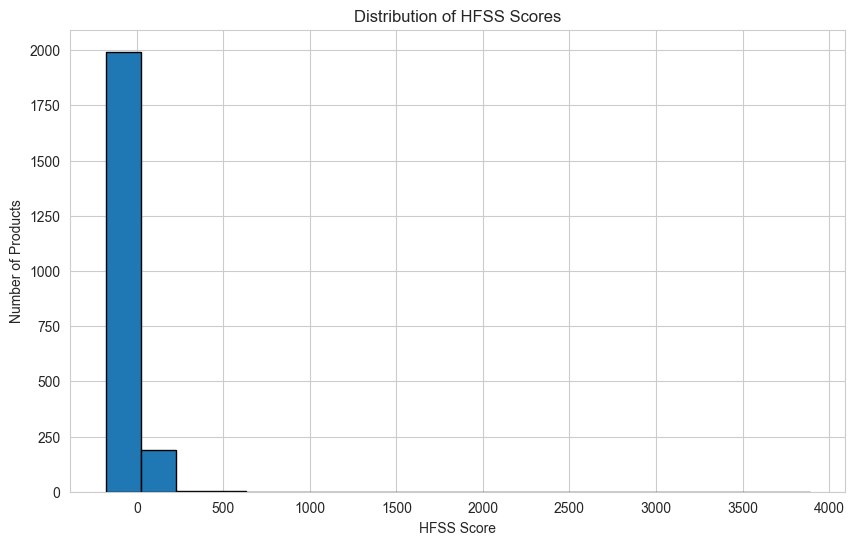

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
opf_data['hfss_score'].dropna().hist(bins=20, edgecolor='black')  # Drop NaN values
plt.title('Distribution of HFSS Scores')
plt.xlabel('HFSS Score')
plt.ylabel('Number of Products')
plt.show()